### https://kaggle.com/competitions/flight-delays-spring-2018

Датасет содержит данные о полетах гражданской авиации в США в 2018 г.\
Таргет - задержан ли вылет самолета на 15 минут и более (да/нет)

__Бизнес-задача__: реализовать классификатор, предсказывающий задержку самолета. \
__Зачем__ : с его помощью аэропорты могут точнее планировать расписание полетов и работу персонала, пассажиры смогут тщательнее планировать свои путешествия, а авиалинии - устранять недочеты с помощью интерпретации признаков, избегать лишних штрафов и простоев авиапарка.

__ML-задача__: Бинарная классификация

__Метрика: F-score__\
На первый взгляд не очевидно, критичнее здесь False Positive или False Negative ошибка. Но мое предположение состоит в том, что максимизировать Recall более целесообразно, нежели Precision. Авиалиниям проще предупредить, что рейс задержится, и тогда остальные участники (пассажиры и аэропорты) будут строить из этого факта свои ожидания и планы. Также авиалинии снижают риски возможных претензий, судов и штрафов. Однако не совсем понятно, насколько "дорого" обойдется такое суждение для авиакомпании : она может закладывать задержку рейса в свою деятельность, но самолеты будут прилетать вовремя и простаивать (а это звучит дорого в плане содержания самолета и экипажа), если мы лишний раз предскажем задержку вылета, будучи действующим сервисом в рамках авиалинии. Поэтому я остановлю свой выбор на F-score, который покрывает обе этих метрики.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [136]:
df = pd.read_csv('flight_delays_train.csv')

In [137]:
df

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y
...,...,...,...,...,...,...,...,...,...
99995,c-5,c-4,c-3,1618,OO,SFO,RDD,199,N
99996,c-1,c-18,c-3,804,CO,EWR,DAB,884,N
99997,c-1,c-24,c-2,1901,NW,DTW,IAH,1076,N
99998,c-4,c-27,c-4,1515,MQ,DFW,GGG,140,N


__В наборе данных содержатся поля:__
* Месяц рейса
* День месяца 
* День недели 
* Время вылета
* Название авиалинии
* Аэропорт отправления
* Аэропорт назначения
* Расстояние между аэропортами
* Факт задержки рейса более, чем на 15 минут

In [4]:
# Заменим даты на соотв. порядковые числа

In [138]:
df['Month'] = df['Month'].str.replace("c-","")
df['DayofMonth'] = df['DayofMonth'].str.replace("c-","")
df['DayOfWeek'] = df['DayOfWeek'].str.replace("c-","")

df['Month'] = df['Month'].astype(int)
df['DayofMonth'] = df['DayofMonth'].astype(int)
df['DayOfWeek'] = df['DayOfWeek'].astype(int)

In [139]:
df

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,8,21,7,1934,AA,ATL,DFW,732,N
1,4,20,3,1548,US,PIT,MCO,834,N
2,9,2,5,1422,XE,RDU,CLE,416,N
3,11,25,6,1015,OO,DEN,MEM,872,N
4,10,7,6,1828,WN,MDW,OMA,423,Y
...,...,...,...,...,...,...,...,...,...
99995,5,4,3,1618,OO,SFO,RDD,199,N
99996,1,18,3,804,CO,EWR,DAB,884,N
99997,1,24,2,1901,NW,DTW,IAH,1076,N
99998,4,27,4,1515,MQ,DFW,GGG,140,N


In [52]:
df.describe()

,Month,DayofMonth,DayOfWeek,DepTime,Distance
count,100000.000000,100000.000000,100000.00000,100000.000000,100000.00000
mean,6.537640,15.703850,3.95183,1341.523880,729.39716
std,3.413447,8.793931,1.99164,476.378445,574.61686
min,1.000000,1.000000,1.00000,1.000000,30.00000
25%,4.000000,8.000000,2.00000,931.000000,317.00000
50%,7.000000,16.000000,4.00000,1330.000000,575.00000
75%,9.000000,23.000000,6.00000,1733.000000,957.00000
max,12.000000,31.000000,7.00000,2534.000000,4962.00000


In [144]:
df.isna().sum()

Month                0
DayofMonth           0
DayOfWeek            0
DepTime              0
UniqueCarrier        0
Origin               0
Dest                 0
Distance             0
dep_delayed_15min    0
dtype: int64

In [134]:
#катег. признаки
cat_features = ['Month', 'DayofMonth','DayOfWeek','UniqueCarrier','Origin','Dest','DepTime']
for feat in df[cat_features]:
    print(feat, 'has unique values', len(np.unique(df[feat])))
#DepTime можно разбить на отдельные признаки "час" и "минуты",но можно и рассматривать как численный признак

Month has unique values 12
DayofMonth has unique values 31
DayOfWeek has unique values 7
UniqueCarrier has unique values 22
Origin has unique values 289
Dest has unique values 289
DepTime has unique values 1300


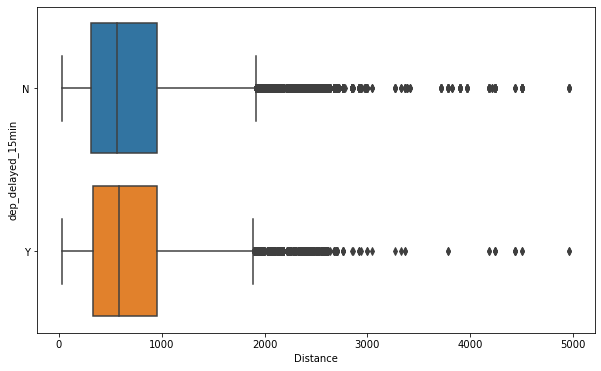

In [91]:
# Преобладают относительно короткие перелеты (примерно 700 км)
# Нет явной зависимости от расстояния, значит надо копать в другие признаки



plt.figure(figsize=(10,6))
sns.boxplot(x=df["Distance"], y=df["dep_delayed_15min"]);

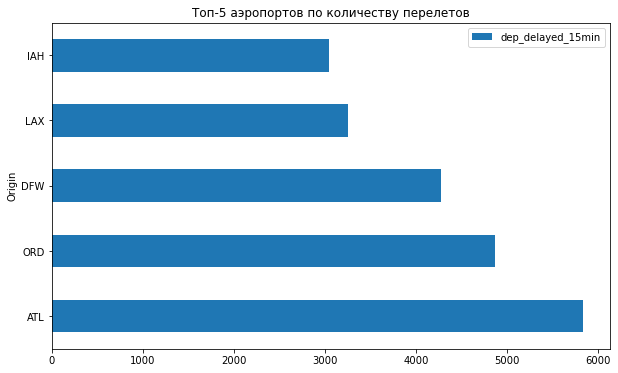

In [53]:
df.groupby('Origin').agg({'dep_delayed_15min':'count'}).\
sort_values(by = 'dep_delayed_15min', ascending = False).head(5).plot(kind = 'barh', figsize= (10,6))
plt.title('Топ-5 аэропортов по количеству перелетов')
plt.show()

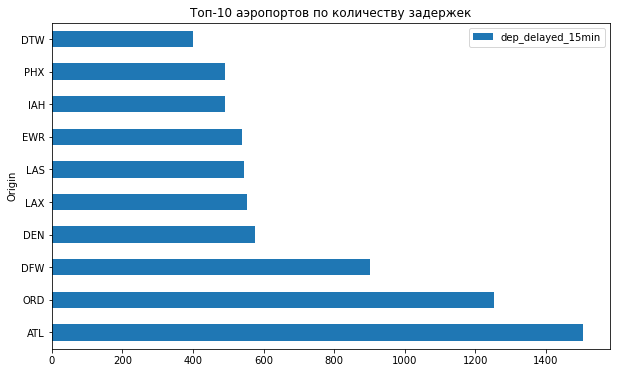

In [48]:
df[df['dep_delayed_15min']=='Y'].groupby('Origin').agg({'dep_delayed_15min':'count'}).\
sort_values(by = 'dep_delayed_15min', ascending = False).head(10).plot(kind = 'barh', figsize= (10,6))
plt.title('Топ-10 аэропортов по количеству задержек')
plt.show()

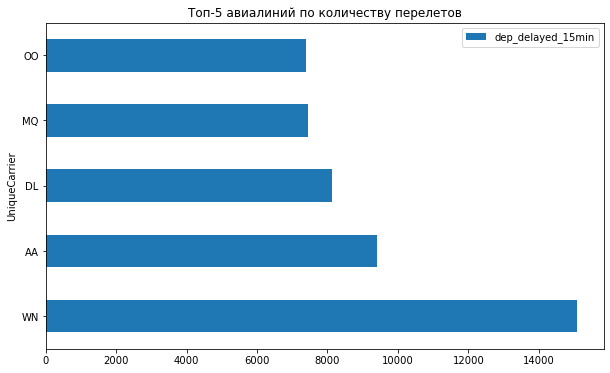

In [54]:
df.groupby('UniqueCarrier').agg({'dep_delayed_15min':'count'}).\
sort_values(by = 'dep_delayed_15min', ascending = False).head(5).plot(kind = 'barh', figsize= (10,6))
plt.title('Топ-5 авиалиний по количеству перелетов')
plt.show()

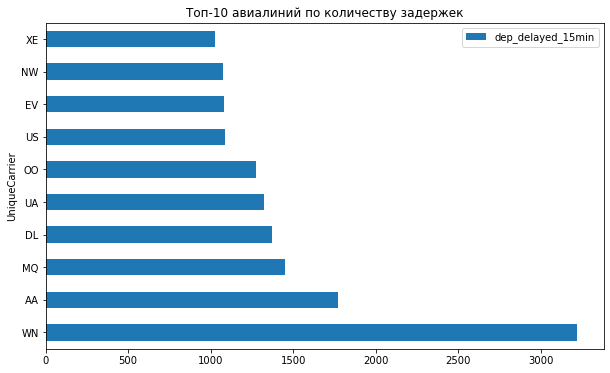

In [51]:
df[df['dep_delayed_15min']=='Y'].groupby('UniqueCarrier').agg({'dep_delayed_15min':'count'}).\
sort_values(by = 'dep_delayed_15min', ascending = False).head(10).plot(kind = 'barh', figsize= (10,6))
plt.title('Топ-10 авиалиний по количеству задержек')
plt.show()

### Наталкивает на мысль о том, что нужно считать долю задержек, а не абсолютное кол-во, потому что крупнейший аэропорт (или авиакомпания) обслуживает попросту больше перелетов

In [60]:

bad_carriers = pd.merge( \
    df[df['ç']=='Y'].groupby('UniqueCarrier').agg({'dep_delayed_15min':'count'}).\
sort_values(by = 'dep_delayed_15min', ascending = False).reset_index(), \
         df.groupby('UniqueCarrier').agg({'dep_delayed_15min':'count'}).\
sort_values(by = 'dep_delayed_15min', ascending = False).reset_index(), on = 'UniqueCarrier' \
        )


/Users/mivff/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


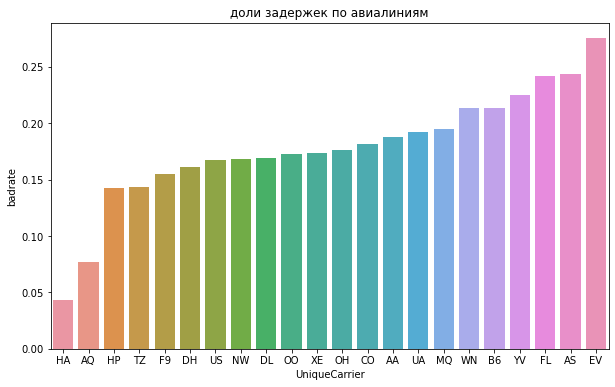

In [115]:
bad_carriers['badrate'] = bad_carriers['dep_delayed_15min_x'] / bad_carriers['dep_delayed_15min_y']
plt.figure(figsize = (10,6))
sns.barplot(bad_carriers['UniqueCarrier'],bad_carriers['badrate'], order = bad_carriers.sort_values(by='badrate').UniqueCarrier)
plt.title('доли задержек по авиалиниям');

In [109]:
bad_carriers.sort_values(by='badrate')

,UniqueCarrier,dep_delayed_15min_x,dep_delayed_15min_y,badrate
20,HA,33,762,0.043307
21,AQ,18,234,0.076923
16,HP,196,1378,0.142235
19,TZ,64,446,0.143498
17,F9,156,1006,0.155070
18,DH,156,966,0.161491
6,US,1085,6482,0.167387
8,NW,1075,6403,0.167890
3,DL,1373,8128,0.168922
5,OO,1277,7390,0.172801


/Users/mivff/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


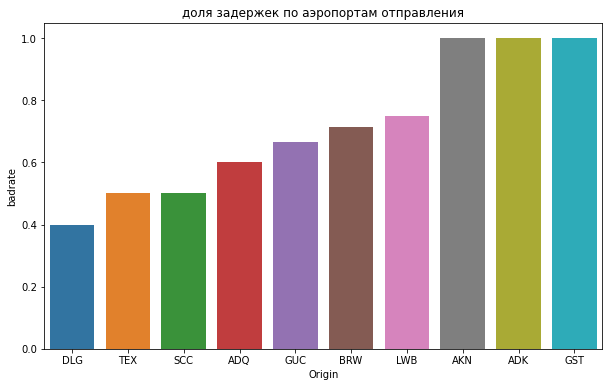

In [117]:
bad_origins = pd.merge( \
    df[df['dep_delayed_15min']=='Y'].groupby('Origin').agg({'dep_delayed_15min':'count'}).\
sort_values(by = 'dep_delayed_15min', ascending = False).reset_index(), \
         df.groupby('Origin').agg({'dep_delayed_15min':'count'}).\
sort_values(by = 'dep_delayed_15min', ascending = False).reset_index(), on = 'Origin' \
        )

bad_origins['badrate'] = bad_origins['dep_delayed_15min_x'] / bad_origins['dep_delayed_15min_y']

bad_origins = bad_origins.sort_values(by='badrate',ascending = False).head(10)

plt.figure(figsize = (10,6))
sns.barplot(bad_origins['Origin'],bad_origins['badrate'], order = bad_origins.sort_values(by='badrate').Origin)
plt.title('доля задержек по аэропортам отправления');

In [94]:
#Не напрашивается вывод о том, что крупнейшие аэропорты и авиалинии имеют бОльшие доли задержек

In [119]:
# есть ли зависимость задержек от месяца?
bad_month = df[df['dep_delayed_15min']=='Y'].groupby('Month').agg({'dep_delayed_15min':'count'}).reset_index()
bad_month

,Month,dep_delayed_15min
0,1,1539
1,2,1316
2,3,1676
3,4,1306
4,5,1313
5,6,1867
6,7,2073
7,8,1783
8,9,1279
9,10,1501


/Users/mivff/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


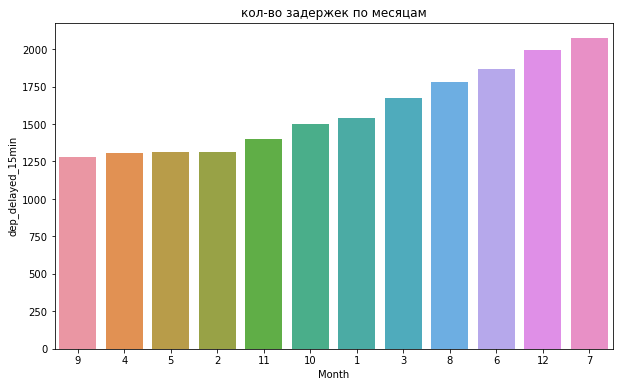

In [121]:
plt.figure(figsize = (10,6))
sns.barplot(bad_month['Month'],bad_month['dep_delayed_15min'], order = bad_month.sort_values(by='dep_delayed_15min').Month)
plt.title('кол-во задержек по месяцам');

#видно, что в рамках этого датасета в июне, июле, декабре задержки чаще всего

In [140]:
# есть ли зависимость задержек от дня недели?
bad_dweek= df[df['dep_delayed_15min']=='Y'].groupby('DayOfWeek').agg({'dep_delayed_15min':'count'}).reset_index()
bad_dweek

,DayOfWeek,dep_delayed_15min
0,1,2774
1,2,2451
2,3,2567
3,4,3117
4,5,3285
5,6,2145
6,7,2705


/Users/mivff/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


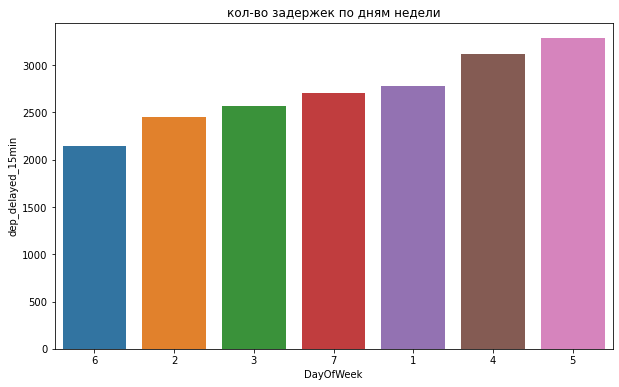

In [143]:
plt.figure(figsize = (10,6))
sns.barplot(bad_dweek['DayOfWeek'],bad_dweek['dep_delayed_15min'], order = bad_dweek.sort_values(by='dep_delayed_15min').DayOfWeek)
plt.title('кол-во задержек по дням недели');

#в этих данных задержки чаще всего по пятницам и четвергам

* кажется, что данных достаточно (10 тыс. наблюдений), чтобы была возможность обучить модель и проверить кач-во
* не совсем очевидно, какие проблемы могут возникнуть в ходе анализа по этим данным
* возможно, для полного анализа еще интересны бы были бинарные переменные о погоде (летная - нелетная)
* пропусков нет
